# Cleaning Data

In [476]:
import time
#from selenium import webdriver
from bs4 import BeautifulSoup
#from webdriver_manager.chrome import ChromeDriverManager
from bs4 import BeautifulSoup
import requests
import re
import os
from lxml import etree
import lxml.html, lxml.html.clean
from urllib.parse import urlparse
from urllib.parse import parse_qs
import pandas as pd
from itertools import product
import time
import regex
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

#driver = webdriver.Chrome(ChromeDriverManager().install())
verbose_flag = True
# htmlSource = driver.page_source

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

### Load data


In [402]:
path_data_scientist = r"C:\Users\RSYeo\Projects\data\data_scientist_2022_03_03.ftr"
path_data_engineer =r"C:\Users\RSYeo\Projects\data\data_engineer_2022_03_03.ftr"
path_data_analyst = r"C:\Users\RSYeo\Projects\data\data_analyst_2022_03_03.ftr"


files = [path_data_scientist, path_data_engineer, path_data_analyst]

In [403]:
df_data_careers = None

start = True
for file_path in files:
    df_read = pd.read_feather(file_path)

    if(start):
        df_data_careers = df_read.copy()
        start = False

    else:
        df_data_careers = pd.concat([df_data_careers, df_read])

df_data_careers.reset_index(drop=True, inplace=True)
        


### Start cleaning data

#### Format ID

In [404]:
# Format job id to be numerical
df_data_careers['job_id'] = df_data_careers.job_id.astype('str').str.extract("(\d+)")

In [405]:
df_data_careers.job_id.nunique()

7851

In [406]:
df_data_careers['job_title'] = df_data_careers['job_title'].str.lower()

#### Drop non-unique jobs

In [407]:
df_data_careers.drop_duplicates(keep='first', subset=['job_id'], inplace=True)

#### Format salary range

In [408]:
#replace wrong values with nan
df_data_careers.loc[df_data_careers['salary_range'].str.contains('Posted'), 'salary_range'] = np.nan

In [409]:
#clean MYR
df_malaysian_salary = df_data_careers.loc[~df_data_careers['salary_range'].isnull() & df_data_careers['salary_range'].str.contains('MYR'), :]


In [410]:
df_malaysian_salary.head()

,job_id,job_title,salary_range,job_description,job_level,experience,job_type,qualifications,job_specialization,company_name,company_registration,company_size,company_industry,job_link,search_term,state
2,4832121,sql database administrator (数据库管理员),"MYR 15,000 - MYR 25,000","Job DescriptionJob Requirements: Must speak, r...",Senior Executive,3 years,Full-Time,"Bachelor's Degree, Post Graduate Diploma, Prof...","Computer/Information Technology, IT-Network/Sy...",Morivy Data and Technology Inc.,None,1 - 50 Employees,Computer / Information Technology (Software),/en/job/sql-database-administrator-%E6%95%B0%E...,data scientist,negeri-sembilan
3,4839272,software engineer,"MYR 3,000 - MYR 4,200",Job Description QualificationDegree or higher ...,Junior Executive,2 years,Full-Time,Not Specified,"Computer/Information Technology, IT-Software",TAIACE ENERGY SDN BHD,1006041-X,1 - 50 Employees,Environment/Health/Safety,/en/job/software-engineer-4839272?jobId=jobstr...,data scientist,negeri-sembilan
4,4852008,manufacturing engineer- fresh graduates (1 yea...,"MYR 3,000 - MYR 3,500",Job HighlightsCareer AdvancementDaily Meal All...,Entry Level,None,Full-Time,"Bachelor's Degree, Post Graduate Diploma, Prof...","Engineering, Electrical, Mechanical",Plexus Manufacturing Sdn Bhd,399136-M,More than 5000 Employees,Electrical & Electronics,/en/job/manufacturing-engineer-fresh-graduates...,data scientist,negeri-sembilan
7,4819995,system support executive,"MYR 1,500 - MYR 2,000",Job DescriptionSystem Support ExecutiveDeliver...,Junior Executive,2 years,Full-Time,Not Specified,"Computer/Information Technology, IT-Software",Infomax Supplies,001423432-A,1 - 50 Employees,Computer/Information Technology (Hardware),/en/job/system-support-executive-4819995?jobId...,data scientist,negeri-sembilan
8,4831057,junior chemist product development laboratory,"MYR 2,500 - MYR 3,300",Job Highlights5-day weekProgressive working en...,Junior Executive,2 years,Full-Time,"Professional Certificate, Diploma, Advanced/Hi...","Sciences, Chemistry",MAPEI MALAYSIA SDN BHD,231780-K,51 - 200 Employees,Manufacturing / Production,/en/job/junior-chemist-product-development-lab...,data scientist,negeri-sembilan


In [411]:
extracted_salary = df_malaysian_salary['salary_range'].str.findall("(\d+,\d+)")

In [412]:
df_malaysian_salary.loc[:,'start_salary_range'] = extracted_salary.str[0]
df_malaysian_salary.loc[:,'end_salary_range'] = extracted_salary.str[1]

C:\Users\RSYeo\AppData\Local\Temp\ipykernel_12800\4207735271.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_malaysian_salary.loc[:,'start_salary_range'] = extracted_salary.str[0]
C:\Users\RSYeo\AppData\Local\Temp\ipykernel_12800\4207735271.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_malaysian_salary.loc[:,'end_salary_range'] = extracted_salary.str[1]


In [413]:
df_malaysian_salary['start_salary_range'] = df_malaysian_salary['start_salary_range'].str.replace(',','')
df_malaysian_salary.loc[:,'end_salary_range'] = df_malaysian_salary.loc[:,'end_salary_range'].str.replace(',','')

C:\Users\RSYeo\AppData\Local\Temp\ipykernel_12800\2981404410.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_malaysian_salary['start_salary_range'] = df_malaysian_salary['start_salary_range'].str.replace(',','')
C:\Users\RSYeo\AppData\Local\Temp\ipykernel_12800\2981404410.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_malaysian_salary.loc[:,'end_salary_range'] = df_malaysian_salary.loc[:,'end_salary_range'].str.replace(',','')


In [414]:
df_malaysian_salary['start_salary_range'] = df_malaysian_salary['start_salary_range'].astype(float)
df_malaysian_salary['end_salary_range'] = df_malaysian_salary['end_salary_range'].astype(float)

C:\Users\RSYeo\AppData\Local\Temp\ipykernel_12800\445547010.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_malaysian_salary['start_salary_range'] = df_malaysian_salary['start_salary_range'].astype(float)
C:\Users\RSYeo\AppData\Local\Temp\ipykernel_12800\445547010.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_malaysian_salary['end_salary_range'] = df_malaysian_salary['end_salary_range'].astype(float)


In [415]:
df_malaysian_salary.shape

(1565, 18)

In [416]:
currencies = df_data_careers['salary_range'].str[:3]

In [417]:
currencies.value_counts()

MYR    1565
SGD       3
HKD       1
Name: salary_range, dtype: int64

In [418]:
#clean SGD
df_singaporean_salary = df_data_careers.loc[~df_data_careers['salary_range'].isnull() & df_data_careers['salary_range'].str.contains('SGD'), :]
extracted_salary_SGD = df_singaporean_salary['salary_range'].str.findall("(\d+,\d+)")
df_singaporean_salary.loc[:,'start_salary_range'] = extracted_salary_SGD.str[0]
df_singaporean_salary.loc[:,'end_salary_range'] = extracted_salary_SGD.str[1]
df_singaporean_salary['start_salary_range'] = df_singaporean_salary['start_salary_range'].str.replace(',','')
df_singaporean_salary.loc[:,'end_salary_range'] = df_singaporean_salary.loc[:,'end_salary_range'].str.replace(',','')

#conversion to MYR
MYR = 3.08
df_singaporean_salary['start_salary_range'] = df_singaporean_salary['start_salary_range'].astype(float)*3.08
df_singaporean_salary['end_salary_range'] = df_singaporean_salary['end_salary_range'].astype(float)*3.08

df_singaporean_salary

C:\Users\RSYeo\AppData\Local\Temp\ipykernel_12800\2162059839.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_singaporean_salary.loc[:,'start_salary_range'] = extracted_salary_SGD.str[0]
C:\Users\RSYeo\AppData\Local\Temp\ipykernel_12800\2162059839.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_singaporean_salary.loc[:,'end_salary_range'] = extracted_salary_SGD.str[1]
C:\Users\RSYeo\AppData\Local\Temp\ipykernel_12800\2162059839.py:6: SettingWithCopyWarning: 
A value is trying to be set on a cop

,job_id,job_title,salary_range,job_description,job_level,experience,job_type,qualifications,job_specialization,company_name,company_registration,company_size,company_industry,job_link,search_term,state,start_salary_range,end_salary_range
0,4839088,big data lead (work in singapore) - 44565,"SGD 7,000 - SGD 10,500",Job HighlightsExciting future with breakthroug...,Manager,7 years,Full-Time,"Bachelor's Degree, Post Graduate Diploma, Prof...","Computer/Information Technology, IT-Software",Keysight Technologies Malaysia Sdn. Bhd.,463532-M,2001 - 5000 Employees,Electrical & Electronics,/en/job/big-data-lead-work-in-singapore-44565-...,data scientist,negeri-sembilan,21560.0,32340.0
6595,9299289,"senior commodity specialist (based in penang, ...","SGD 2,000 - SGD 3,000",Job DescriptionResponsibilities:Manages the ou...,Junior Executive,None,Full-Time,"Bachelor's Degree, Post Graduate Diploma, Prof...","Manufacturing, Purchasing/Material Mgmt",ASM Front-End Manufacturing Singapore Pte Ltd,200310868G,201 - 500 Employees,Semiconductor/Wafer Fabrication,/en/job/senior-commodity-specialist-based-in-p...,data analyst,penang,6160.0,9240.0
6713,9299313,"senior buyer (penang, malaysia)","SGD 2,000 - SGD 3,000",Job DescriptionResponsibilities:Responsible fo...,Junior Executive,None,Full-Time,"Bachelor's Degree, Post Graduate Diploma, Prof...","Manufacturing, Purchasing/Material Mgmt",ASM Front-End Manufacturing Singapore Pte Ltd,200310868G,201 - 500 Employees,Semiconductor/Wafer Fabrication,/en/job/senior-buyer-penang-malaysia-9299313/o...,data analyst,penang,6160.0,9240.0


In [419]:
#clean HKD
df_hongkong_salary = df_data_careers.loc[~df_data_careers['salary_range'].isnull() & df_data_careers['salary_range'].str.contains('HKD'), :]
extracted_salary_HKD = df_hongkong_salary['salary_range'].str.findall("(\d+,\d+)")
df_hongkong_salary.loc[:,'start_salary_range'] = extracted_salary_HKD.str[0]
df_hongkong_salary.loc[:,'end_salary_range'] = extracted_salary_HKD.str[1]
df_hongkong_salary['start_salary_range'] = df_hongkong_salary['start_salary_range'].str.replace(',','')
df_hongkong_salary.loc[:,'end_salary_range'] = df_hongkong_salary.loc[:,'end_salary_range'].str.replace(',','')

#conversion to MYR
MYR = 0.54
df_hongkong_salary['start_salary_range'] = df_hongkong_salary['start_salary_range'].astype(float)*MYR
df_hongkong_salary['end_salary_range'] = df_hongkong_salary['end_salary_range'].astype(float)*MYR

df_hongkong_salary

C:\Users\RSYeo\AppData\Local\Temp\ipykernel_12800\3422634028.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_hongkong_salary.loc[:,'start_salary_range'] = extracted_salary_HKD.str[0]
C:\Users\RSYeo\AppData\Local\Temp\ipykernel_12800\3422634028.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_hongkong_salary.loc[:,'end_salary_range'] = extracted_salary_HKD.str[1]
C:\Users\RSYeo\AppData\Local\Temp\ipykernel_12800\3422634028.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a

,job_id,job_title,salary_range,job_description,job_level,experience,job_type,qualifications,job_specialization,company_name,company_registration,company_size,company_industry,job_link,search_term,state,start_salary_range,end_salary_range
3908,4845280,system analyst / senior analyst programmer (ba...,"HKD 25,000 - HKD 35,000",Job DescriptionAbout this roleRegional support...,Senior Executive,5 years,Full-Time,Not Specified,"Computer/Information Technology, IT-Software",Nexperia Malaysia Sdn.Bhd.,244835-W,2001 - 5000 Employees,Semiconductor/Wafer Fabrication,/en/job/system-analyst-senior-analyst-programm...,data analyst,selangor,13500.0,18900.0


In [420]:
df_data_careers['start_salary_range'] = np.nan
df_data_careers['end_salary_range'] = np.nan

In [421]:
def update_data(main_df:pd.DataFrame, new_df:pd.DataFrame, column_names:list):
    for column_name in column_names:
        main_df.loc[new_df.index, column_name] = new_df[column_name]
    
    return main_df

In [422]:
new_data_dfs = [df_malaysian_salary, df_singaporean_salary, df_hongkong_salary]

for df in new_data_dfs:
    df_data_careers = update_data(df_data_careers, df, ['start_salary_range', 'end_salary_range'])


In [423]:
df_data_careers.drop('salary_range', axis=1, inplace=True)

#### Clean experience

In [424]:
df_clean_experience = df_data_careers.copy()
df_clean_experience['experience'] = df_data_careers['experience'].str.replace('years', '')
df_clean_experience['experience'] = df_clean_experience['experience'].str.replace('year', '')

df_clean_experience['experience'] = df_clean_experience['experience'].str.strip()
df_clean_experience.loc[df_clean_experience[df_clean_experience['experience'].isnull()].index, 'experience'] = '0'
df_clean_experience['experience'] = df_clean_experience['experience'].astype(int)
df_clean_experience.head(10)

df_data_careers = df_clean_experience.copy()

#### Filter relevant jobs

In [425]:
df_filtered_data = []

In [426]:
df_data_careers.shape

(7851, 17)

Get all jobs mentioning data

In [427]:
df_data_only = df_data_careers[df_data_careers.job_title.str.contains('data')].copy()
df_data_only.shape

(571, 17)

In [428]:
df_filtered_data.append(df_data_only)

In [429]:
df_no_data = df_data_careers.drop(df_data_only.index)

Get all jobs mentioning computer science

In [430]:
df_computer_science = df_no_data[df_no_data['job_title'].str.contains('science|scientist') & df_no_data['job_title'].str.contains('computer')].copy()

In [431]:
df_filtered_data.append(df_computer_science)

In [432]:
df_no_computer_science = df_no_data.drop(df_computer_science.index)

Get all jobs mentioning machine learning

In [433]:
df_machine_learning = df_no_computer_science[df_no_computer_science['job_title'].str.contains('machine learning')].copy()

In [434]:
df_filtered_data.append(df_machine_learning)

In [435]:
df_no_machine_learning = df_no_computer_science.drop(df_machine_learning.index)

Get all software jobs mentioning analytics, machine learning, artificial intelligence in description

In [436]:
df_software_analytics = df_no_machine_learning[df_no_machine_learning['job_title'].str.contains('software') & df_no_machine_learning['job_description'].str.contains('artificial|intelligence|analytics|machine learning')]

In [437]:
df_filtered_data.append(df_software_analytics)

In [438]:
df_no_software_analytics = df_no_machine_learning.drop(df_software_analytics.index)

Get all jobs mentioning artificial intelligence and machine learning

In [439]:
df_misc = df_no_software_analytics[df_no_software_analytics['job_description'].str.contains('machine learning|artificial intelligence|data science|data engineering')]
df_ai = df_misc[df_misc['job_title'].str.contains(r'\ba\W*i\b', regex=True)]

In [440]:
df_filtered_data.append(df_ai)

In [441]:
df_misc_no_ai = df_misc.drop(df_ai.index)
df_misc_no_ai.shape


(219, 17)

In [442]:
df_intelligence = df_misc_no_ai[df_misc_no_ai['job_title'].str.contains('ml ops|mlops|analytics|smart|application scientist|chief|analytics|business intelligence|architect|analytics|intelligent|automation',regex=True)]

In [443]:
df_filtered_data.append(df_intelligence)

### Join back all filtered DF

In [444]:
df_all_data_jobs_cleaned = None
start = True

for df in df_filtered_data:
    if(start):
        df_all_data_jobs_cleaned = df.copy()
        start = False

    else:
        df_all_data_jobs_cleaned = pd.concat([df_all_data_jobs_cleaned, df])

df_all_data_jobs_cleaned.shape


(689, 17)

In [445]:
df_dropped = df_data_careers.drop(df_all_data_jobs_cleaned.index)

In [446]:
df_business_intelligence = df_dropped[df_dropped['job_title'].str.contains(r'business intelligence|analytics|intelligence|power bi|\bb\W*i\b')]

In [447]:
df_all_data_jobs_cleaned = pd.concat([df_all_data_jobs_cleaned, df_business_intelligence])

In [457]:
stragglers = df_dropped[df_dropped['job_title'].str.contains(r'artificial intelligence|\ba\W*i\b|mlops|data engineering|data engineer')]

,job_id,job_title,job_description,job_level,experience,job_type,qualifications,job_specialization,company_name,company_registration,company_size,company_industry,job_link,search_term,state,start_salary_range,end_salary_range
1237,1030521725,junior ai engineer (penang),Job DescriptionDescription- Research and devel...,Not Specified,0,Contract,Not Specified,"Computer/Information Technology, IT-Software",Skymind Holdings,1303705-V,51 - 200 Employees,Computer / Information Technology (Software),/en/job/junior-ai-engineer-penang-1030521725?j...,data scientist,penang,NaN,NaN
1451,4820889,artificial intelligence engineer (internship),Job DescriptionWhat you will be doing:Conduct ...,Entry Level,0,Internship,"Bachelor's Degree, Post Graduate Diploma, Prof...","Computer/Information Technology, IT-Software",SUPERCEED (M) SDN BHD,830277D,1 - 50 Employees,Call Center/IT-Enabled Services/BPO,/en/job/artificial-intelligence-engineer-inter...,data scientist,kuala-lumpur,1000.0,NaN
2107,1030601644,mlops engineer,Job DescriptionJob ResponsibilityWe are Hiring...,Not Specified,0,Full-Time,Not Specified,"Computer/Information Technology, IT-Network/Sy...",BigPay Malaysia,719679-A,51 - 200 Employees,Banking / Financial Services,/en/job/mlops-engineer-1030601644?jobId=jobstr...,data scientist,kuala-lumpur,NaN,NaN


In [458]:
df_all_data_jobs_cleaned = pd.concat([df_all_data_jobs_cleaned, stragglers])

In [461]:
df_dropped = df_dropped.drop(stragglers.index)

### EDA for data related jobs

In [465]:
df_data_jobs = df_all_data_jobs_cleaned.drop_duplicates('job_id')


In [466]:
df_data_jobs[~df_data_jobs['start_salary_range'].isna()].shape

(115, 17)

In [467]:
df_data_jobs['job_id'].nunique()

799

In [468]:
df_data_jobs.head(1)

,job_id,job_title,job_description,job_level,experience,job_type,qualifications,job_specialization,company_name,company_registration,company_size,company_industry,job_link,search_term,state,start_salary_range,end_salary_range
0,4839088,big data lead (work in singapore) - 44565,Job HighlightsExciting future with breakthroug...,Manager,7.0,Full-Time,"Bachelor's Degree, Post Graduate Diploma, Prof...","Computer/Information Technology, IT-Software",Keysight Technologies Malaysia Sdn. Bhd.,463532-M,2001 - 5000 Employees,Electrical & Electronics,/en/job/big-data-lead-work-in-singapore-44565-...,data scientist,negeri-sembilan,21560.0,32340.0


In [480]:
df_jobs_by_state = df_data_jobs.groupby('state').size()
df_jobs_by_state


state
johor               16
kedah                7
kuala-lumpur       414
melaka               7
negeri-sembilan      6
pahang               3
penang              64
perak                2
perlis               2
sabah                2
sarawak              9
selangor           267
dtype: int64

C:\Users\RSYeo\Projects\venv\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 0, 'States')

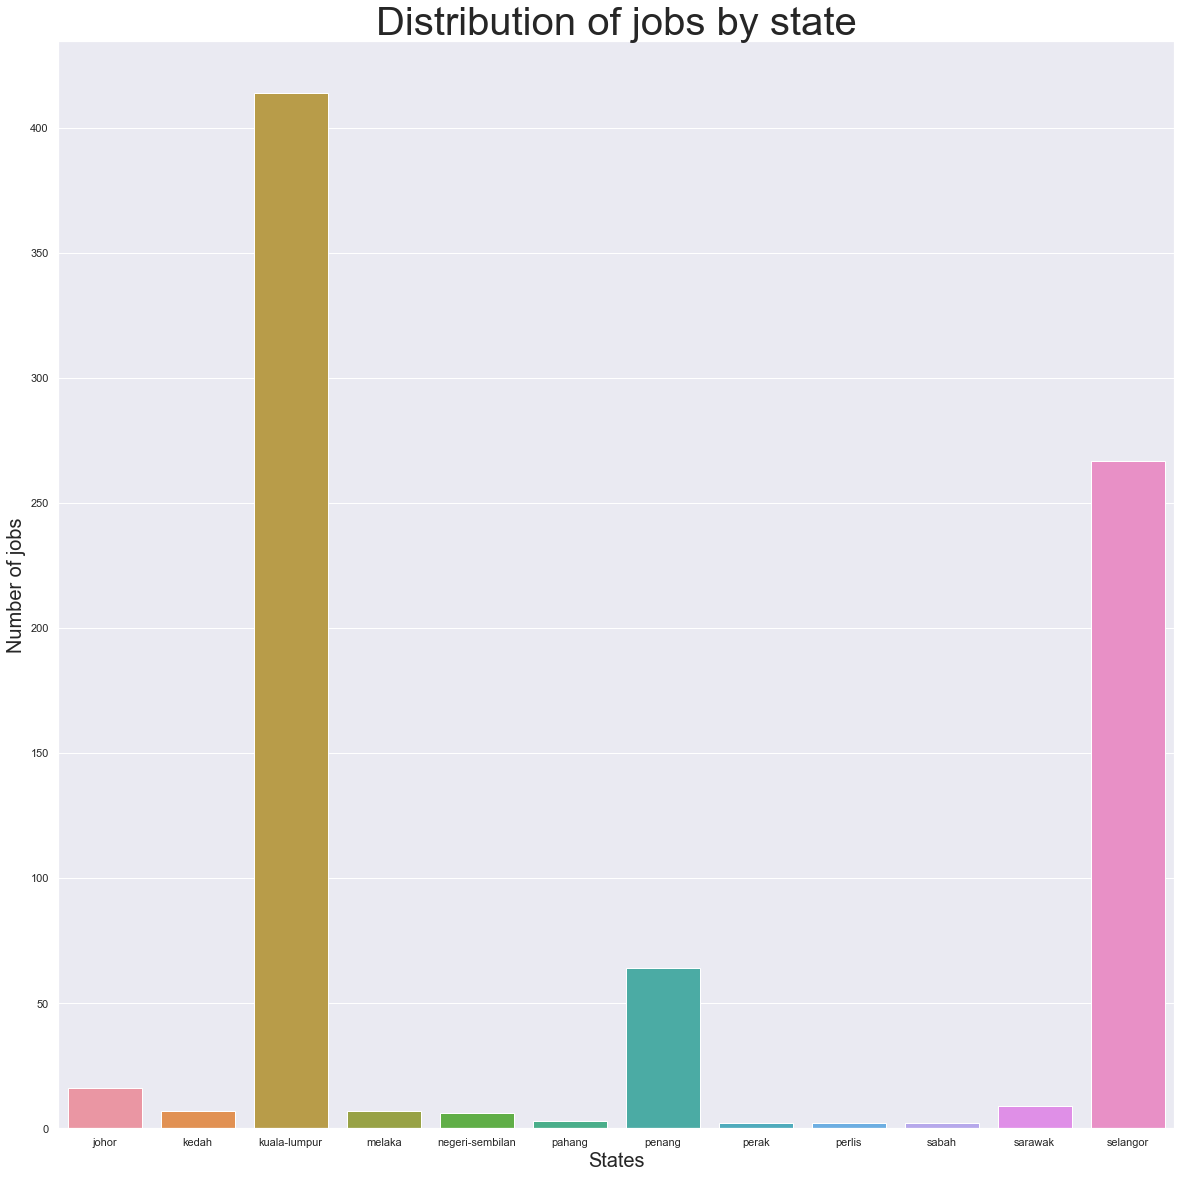

In [494]:
sns.set(rc={'figure.figsize':(20,20)})
bar = sns.barplot(df_jobs_by_state.index, df_jobs_by_state.values)
bar.set_title("Distribution of jobs by state", fontsize=40)
bar.set_ylabel("Number of jobs", fontsize=20)
bar.set_xlabel("States", fontsize=20)

In [491]:
df_jobs_by_industry = df_data_jobs.groupby('company_industry').size()
df_jobs_by_industry

company_industry
Accounting / Audit / Tax Services                      3
Advertising / Marketing / Promotion / PR              13
Aerospace / Aviation / Airline                         5
Agricultural / Plantation / Poultry / Fisheries        3
Apparel                                                1
Arts / Design / Fashion                                2
Automobile / Automotive Ancillary / Vehicle            9
Banking / Financial Services                          81
BioTechnology/Pharmaceutical/Clinical research         6
Call Center/IT-Enabled Services/BPO                   20
Chemical/Fertilizers/Pesticides                        3
Computer / Information Technology (Software)         151
Computer/Information Technology (Hardware)             9
Construction / Building / Engineering                  3
Consulting (Business & Management)                    47
Consulting (IT, Science, Engineering & Technical)     52
Consumer Products / FMCG                              14
Education     